In [1]:
import rebound
import time
import sys
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy import constants as c

# local imports
import heartbeat
import globs
import metasim

In [2]:
def run_sim(filestem='test/test'):
    
    # global variables

    globs.initialise()

    globs.glob_dclo = 1. #CE distance to check in rH
    #dir = 'test/'
    globs.glob_archive = ''
    #globals.glob_names = []
    globs.glob_is_close = False

    system = metasim.MetaSim(filestem=filestem)
    system.run_planets()
    if globs.glob_is_close:
        system.rewind()
        system.add_moons()
        system.run_moons()
        system.analyse()
        system.make_timeline()

Simulation test/test0099

Creating new simulation...
Running planets-only simulation...
Planets-only simulation complete
19.0 years took 0.042714834213256836 seconds
Rewinding simulation...
Simulation rewound 1 years
Adding moons...
Moons added
Running moons simulation...


/Users/alexander/research/circumplanetary_discs/rebound/rebound/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


Europa2 removed by collision with Planet1 at 19.060418594434303 years
<rebound.particle.Particle object at 0x7fcb89102540, m=2.4132719585292833e-08 x=-0.09530231470582533 y=1.9200993879618145 z=-0.03218765182433134 vx=-2.028018696171954 vy=2.5866782882903387 vz=5.271314174178591>
<rebound.particle.Particle object at 0x7fcb89102040, m=0.0019091884679386499 x=-0.09462653959231268 y=1.9211297847722912 z=-0.031137194362826585 vx=-6.892687980998501 vy=-0.43037423312978845 vz=-1.1602387447927003>
Orbelts: a = 0.003974796954700434 au; e = 0.9636520252535211 ; I = 0.8722787535404632 ; Omega = -1.3533810676085687; omega = 1.5874862315485316 ; MA = 6.134632132374174
Current planets: Planet1 Planet2
CE between Planet1 and Planet2 with dist 0.006811839904579082 au at 19.061110682821933 years
<rebound.particle.Particle object at 0x7fcb89102040, m=0.0019092126006582351 x=-0.09935522634922614 y=1.9204995441487813 z=-0.03204747541825754 vx=-6.666133812702983 vy=-1.4115321842520299 vz=-1.43568878223846

CE between Planet1 and Planet2 with dist 0.12572345012412742 au at 274.8844079890898 years
<rebound.particle.Particle object at 0x7fcb793145c0, m=0.0019092816418694433 x=0.8468840550359185 y=1.6574487819282742 z=-0.04744860058460485 vx=-3.400449223235089 vy=1.8105068713888572 vz=0.5616483667846063>
<rebound.particle.Particle object at 0x7fcb89102340, m=0.0019091884679386499 x=0.9682346071382716 y=1.6886396037558031 z=-0.03707738805706633 vx=-3.4913874061418944 vy=2.508710582454974 vz=-0.47126840258979025>
CE between Planet2 and Planet1 with dist 0.12572345012412742 au at 274.8844079890898 years
<rebound.particle.Particle object at 0x7fcb793149c0, m=0.0019091884679386499 x=0.9682346071382716 y=1.6886396037558031 z=-0.03707738805706633 vx=-3.4913874061418944 vy=2.508710582454974 vz=-0.47126840258979025>
<rebound.particle.Particle object at 0x7fcb79314940, m=0.0019092816418694433 x=0.8468840550359185 y=1.6574487819282742 z=-0.04744860058460485 vx=-3.400449223235089 vy=1.8105068713888572 v

CE between Planet1 and Planet2 with dist 0.050108111947725915 au at 677.830592655717 years
<rebound.particle.Particle object at 0x7fcb79314c40, m=0.0019092816418694433 x=-1.0720722026975353 y=1.556207428457333 z=0.017155314861471517 vx=-3.9334189578821124 vy=-1.6805044198980021 vz=-0.0048779245453003375>
<rebound.particle.Particle object at 0x7fcb891020c0, m=0.0019091884679386499 x=-1.0852216314266574 y=1.53866741105303 z=-0.027903127150212825 vx=-2.51830092161784 vy=-3.4051991123589347 vz=0.2520617335616815>
CE between Planet2 and Planet1 with dist 0.050108111947725915 au at 677.830592655717 years
<rebound.particle.Particle object at 0x7fcb79314140, m=0.0019091884679386499 x=-1.0852216314266574 y=1.53866741105303 z=-0.027903127150212825 vx=-2.51830092161784 vy=-3.4051991123589347 vz=0.2520617335616815>
<rebound.particle.Particle object at 0x7fcb793147c0, m=0.0019092816418694433 x=-1.0720722026975353 y=1.556207428457333 z=0.017155314861471517 vx=-3.9334189578821124 vy=-1.68050441989800

/Users/alexander/research/circumplanetary_discs/rebound/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.8189901619183912 e=0.052893099517479385
Ganymede1 bound to Galaxy: a=-1.9923606307194157 e=2.9734514296019046
Callisto1 bound to EPIC220208795: a=1.182099860329564 e=0.4463653042186597
Ganymede2 bound to EPIC220208795: a=1.0262158590793753 e=0.8662001339848021
Callisto2 bound to EPIC220208795: a=1.101779301154129 e=0.7570932904778587


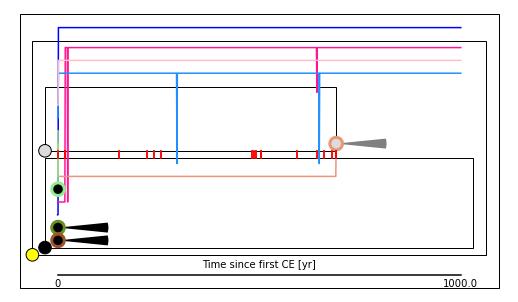

In [9]:
#Nsys = 1

#for i in range(Nsys):
#    run_sim(filestem=f'test/test{i:04d}')

i = 99
run_sim(filestem=f'test/test{i:04d}')